# Self-Driving Car ND : P3 - Behavioural Cloning 

## The below code building two different ConvNet to predict steering angle based on camera inputs. The first is a ConvNet based on LeNet architecture and the second is based on the NVIDIA model for autonomous driving. 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [59]:
import csv 
import cv2 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Prepare the data

In [3]:
def process_image(filepath): 
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image 

In [26]:
def load_data(paths): 
    
    filenames = [] 
    measurements = [] 
    
    for path in paths: 
        image_path = path + 'IMG/'
        with open(path + 'driving_log.csv') as csvfile: 
            reader = csv.reader(csvfile)
            for line in reader: 
                steering = line[3].strip()
                measurement = float(steering)
                center_img = line[0].split('/')[-1]
                filenames.append(image_path + center_img)
                measurements.append(measurement)
            
    ids = range(0, len(filenames))
    return (ids, filenames, measurements)

In [28]:
paths = ['data5/', 'data2/', 'data3/']
data = load_data(paths)
print (data[0][0], data[1][0], data[2][0])

0 data5/IMG/center_2016_12_01_13_30_48_287.jpg 0.0


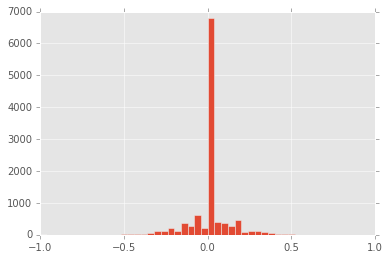

In [29]:
y_orig = np.array(data[2])
plt.hist(y_orig, bins=50)
plt.show()

In [30]:
def balanced_subsample(data,size):

    x = np.array(data[0])
    y = np.array(data[2])
    class_xs = []

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        num = len(this_xs) 
        if num > size:
            np.random.shuffle(this_xs)
            x_ = this_xs[:size]
            y_ = np.empty(size)
            y_.fill(ci)
        else: 
            x_ = this_xs[:]
            y_ = np.empty(num)
            y_.fill(ci)
            
        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [31]:
x_sample,y_sample = balanced_subsample(data, size=150)
f_sample = [data[1][i] for i in x_sample]

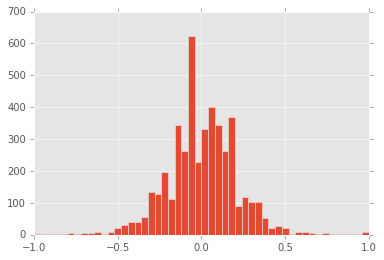

In [33]:
plt.hist(y_sample, bins=50)
plt.show()

In [34]:
def load_images(f_sample, y_sample):
    x = []
    y = []

    for filepath, yi in zip(f_sample, y_sample): 
        image = process_image(filepath)
        x.append(image)
        y.append(yi)
        image_flipped = np.fliplr(image)
        yi_flipped = -yi
        x.append(image_flipped)
        y.append(yi_flipped)

    x = np.array(x)
    y = np.array(y)
    return x,y

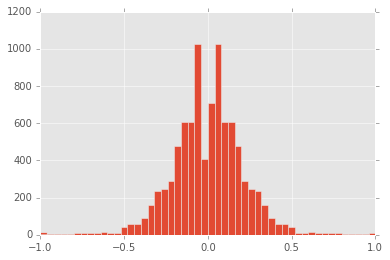

In [36]:
x,y = load_images(f_sample, y_sample)
plt.hist(y, bins=50)
plt.show()

In [47]:
samples = [s for s in zip(f_sample, y_sample)]
train_samples, validation_samples = train_test_split(samples, test_size=0.25)
print (len(train_samples), len(validation_samples))

3432 1145


In [48]:
def augment(filepath, measurement, train=True): 
    
    images = [] 
    measurements = [] 
    
    filepath_right = filepath.replace("center", "right")
    
    image = process_image(filepath)
    images.append(image)
    measurements.append(measurement)
    
    image_flipped = np.fliplr(image)
    measurement_flipped = -measurement
    images.append(image_flipped)
    measurements.append(measurement_flipped)
    
    image_hsv = hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    val = np.random.uniform(0.2,0.8)
    image_hsv[:,:,2] = image_hsv[:,:,2]*val
    images.append(image_hsv)
    measurements.append(measurement)

    image_flipped_hsv = cv2.cvtColor(image_flipped, cv2.COLOR_BGR2HSV)
    val = np.random.uniform(0.2,0.8)
    image_flipped_hsv[:,:,2] = image_flipped_hsv[:,:,2]*val
    images.append(image_flipped_hsv)
    measurements.append(measurement_flipped)    
    
    if train: 
        filepath_left = filepath.replace("center", "left")
        image = process_image(filepath_left)
        images.append(image)
        measurements.append(measurement)

        image_flipped = np.fliplr(image)
        measurement_flipped = -measurement
        images.append(image_flipped)
        measurements.append(measurement_flipped)

        image_hsv = hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        val = np.random.uniform(0.2,0.8)
        image_hsv[:,:,2] = image_hsv[:,:,2]*val
        images.append(image_hsv)
        measurements.append(measurement)

        image_flipped_hsv = cv2.cvtColor(image_flipped, cv2.COLOR_BGR2HSV)
        val = np.random.uniform(0.2,0.8)
        image_flipped_hsv[:,:,2] = image_flipped_hsv[:,:,2]*val
        images.append(image_flipped_hsv)
        measurements.append(measurement_flipped)
        
        filepath_right = filepath.replace("center", "right")
        image = process_image(filepath_right)
        images.append(image)
        measurements.append(measurement)

        image_flipped = np.fliplr(image)
        measurement_flipped = -measurement
        images.append(image_flipped)
        measurements.append(measurement_flipped)

        image_hsv = hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        val = np.random.uniform(0.2,0.8)
        image_hsv[:,:,2] = image_hsv[:,:,2]*val
        images.append(image_hsv)
        measurements.append(measurement)

        image_flipped_hsv = cv2.cvtColor(image_flipped, cv2.COLOR_BGR2HSV)
        val = np.random.uniform(0.2,0.8)
        image_flipped_hsv[:,:,2] = image_flipped_hsv[:,:,2]*val
        images.append(image_flipped_hsv)
        measurements.append(measurement_flipped)        
    
    return (images, measurements)

In [102]:
def generator(samples, train_flag, batch_size=64):
    
    if train_flag: 
        size = int(batch_size / 12) # augment() produces 12 images for every image  
    else: 
        size = int(batch_size / 4) 
    
#     print (size) 
        
    size = 1 if size == 0 else size
    num_samples = len(samples)

    while 1:  
        shuffle(samples)
        for offset in range(0, num_samples, size):
            batch_samples = samples[offset:offset+size]
            x = []
            y = []
            for filepath, measurement in batch_samples:
                images, measurements = augment(filepath, measurement, train_flag)
                x.extend(images)
                y.extend(measurements)

#             print (len(x), len(y))                
            yield shuffle(np.array(x), np.array(y))
#             yield (np.array(x), np.array(y))

In [103]:
train_generator = generator(train_samples, train_flag=True, batch_size=60)
validation_generator = generator(validation_samples, train_flag=False, batch_size=60)

### Model

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D

img_rows, img_cols, img_chls = x[1].shape

### LeNet Architecture

In [ ]:
# keep_prob = 0.2
# batch_size = 128 
# epochs = 5

# model = Sequential()
# model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=x.shape[1:]))
# model.add(Cropping2D(cropping=((70,25), (0,0))))
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(keep_prob))
# model.add(Flatten())
# model.add(Dense(120))
# model.add(Dropout(keep_prob))
# model.add(Dense(80))
# model.add(Dropout(keep_prob))
# model.add(Dense(1))

# model.compile(loss='mse',
#               optimizer='adam'
#              )

# model.fit(x, y,
#           batch_size=batch_size,
#           validation_split = 0.2,
#           epochs=epochs,
#           verbose=1, 
#           shuffle=True
#          )
          
# model.save('model_lenet.h5')

### NVIDIA Architecture

In [74]:
keep_prob = 0.2

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=x.shape[1:]))
model.add(Cropping2D(cropping=((70,25), (0,0))))
model.add(Conv2D(32, kernel_size=(5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(64, kernel_size=(5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), activation='relu'))
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(keep_prob))
model.add(Dense(32))
model.add(Dropout(keep_prob))
model.add(Dense(8))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_6 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 31, 158, 32)       2432      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 77, 64)        51264     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 37, 48)         76848     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 35, 96)         41568     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 33, 128)        110720    
__________

In [ ]:
epochs = 2

model.compile(loss='mse',
              optimizer='adam'
             )

# history_object = model.fit(x, y,
#           batch_size=batch_size,
# #           validation_split = 0.2,
#           epochs=epochs,
#           verbose=1, 
#           shuffle=True
#          )

history = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*12, nb_epoch=epochs, validation_data=validation_generator, nb_val_samples=len(validation_samples)*4)

model.save('model_nvidia.h5')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:15: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=41184, epochs=4, validation_steps=4580, validation_data=<generator...)`


Epoch 1/4
41184/41184 [==============================] - 28878s - loss: 0.0121 - val_loss: 0.0275
Epoch 2/4
32323/41184 [======================>.......] - ETA: 6006s - loss: 0.0046

In [ ]:
# keep_prob = 0.25
# batch_size = 128 
# epochs = 4

# model = Sequential()
# model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=x.shape[1:]))
# model.add(Cropping2D(cropping=((70,25),(0,0))))

# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# # model.add(MaxPooling2D())
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# # model.add(MaxPooling2D())
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# # model.add(MaxPooling2D())
# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())
# model.add(Dense(128))
# model.add(Dense(32))
# model.add(Dense(1))

# model.compile(loss='mse',
#               optimizer='adam'
#              )

# history_object = model.fit(x, y,
#           batch_size=batch_size,
#           validation_split = 0.2,
#           epochs=epochs,
#           verbose=1, 
#           shuffle=True
#          )

# model.save('model_vgg.h5')

In [ ]:
from keras.models import Model

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()